# 🚀 Project: Concrete Crack Detection with CNNs

**Team members:** Oliver, Patrick  
**Date:** 13.12.2025

Using device: cuda
Validation Set Loaded: 6000 images
Loading MobileNetV2 (Epoch 6)...
-> Weights loaded successfully.
Loading OPNet (Epoch 9)...
-> Weights loaded successfully.

--- Finding Errors (MobileNetV2) ---
--- Finding Errors (OPNet) ---


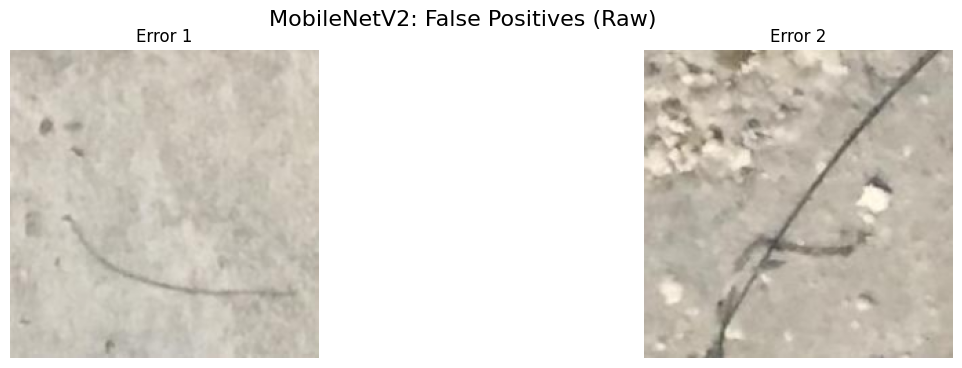

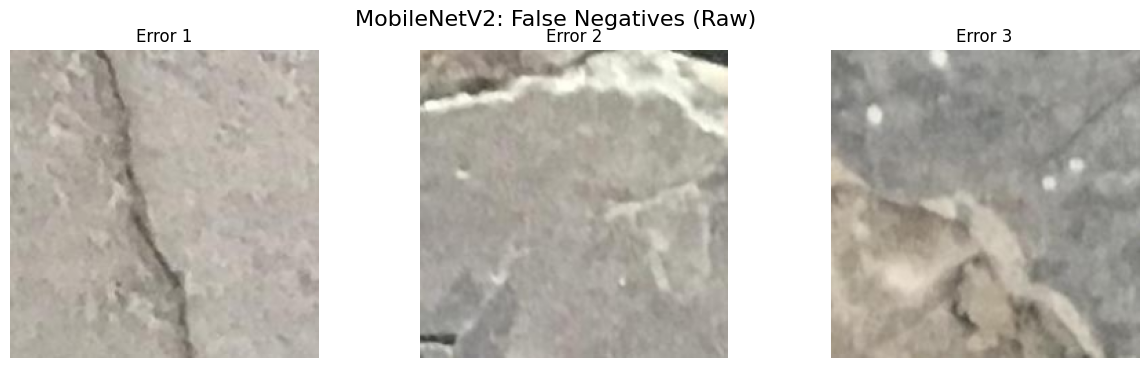

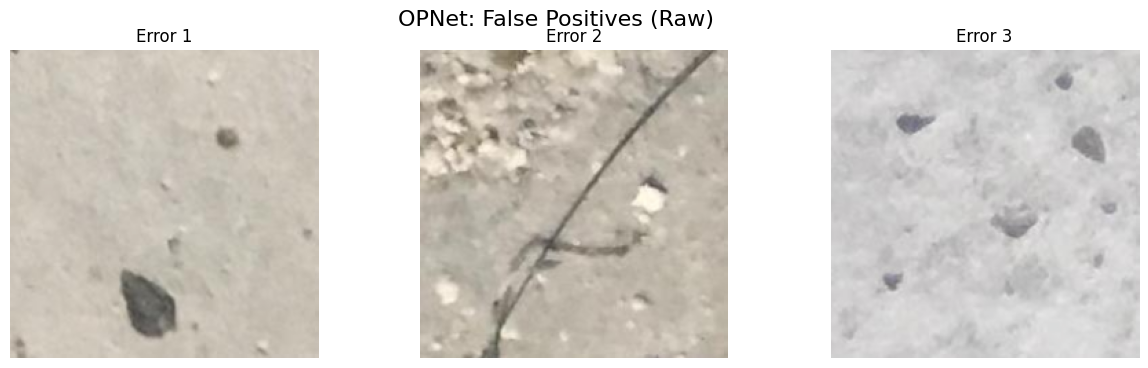

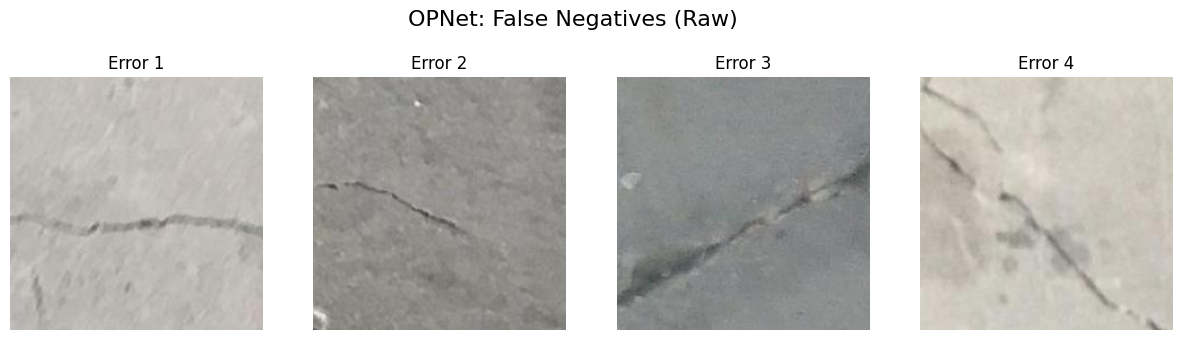


--- Grad-CAM Analysis: MobileNetV2 ---


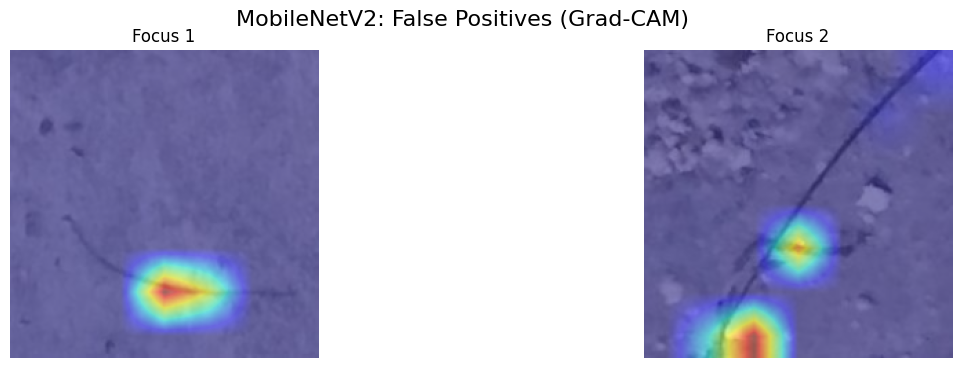

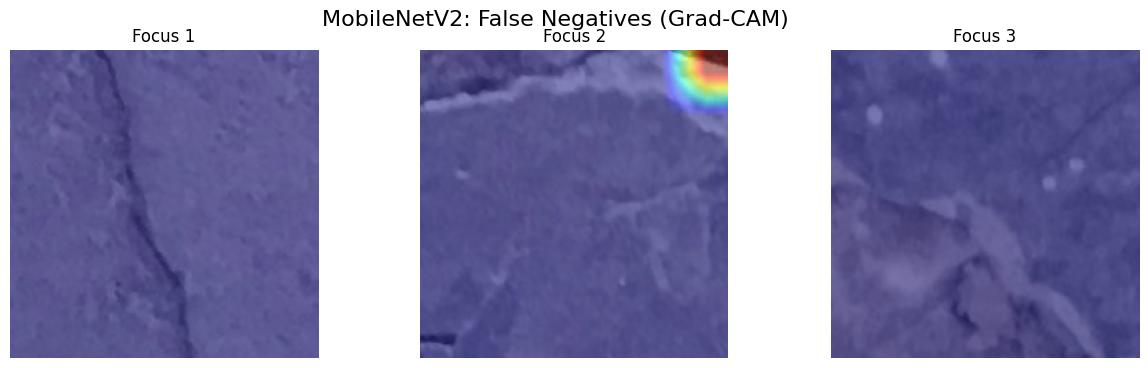


--- Grad-CAM Analysis: OPNet ---


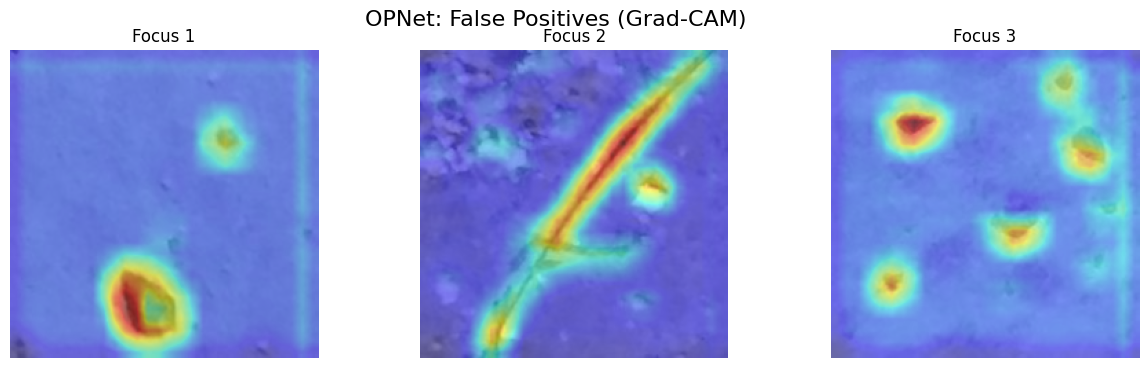

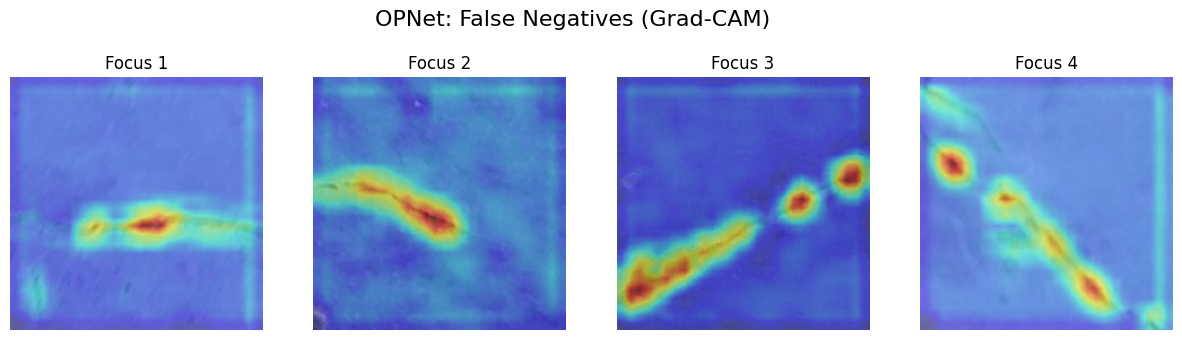

In [6]:
# =============================================================================
# COMPLETE ANALYSIS NOTEBOOK (Steps 10 & 11)
# =============================================================================

# --- 1. Imports & Setup ---
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Paths & Data Loading ---
BASE_DIR = os.getcwd()
DATASET_ZIP_PATH = os.path.join(BASE_DIR, "archive.zip")
EXTRACT_PATH = os.path.join(BASE_DIR, "concrete_data")
MODEL_DIR = os.path.join(BASE_DIR, "models") 

POSITIVE_DIR_NAME = "Positive"
NEGATIVE_DIR_NAME = "Negative"

# Extract if needed
if not os.path.exists(EXTRACT_PATH):
    if os.path.exists(DATASET_ZIP_PATH):
        print("Extracting dataset...")
        with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Extraction complete.")
    else:
        raise FileNotFoundError("archive.zip not found! Please place it in the notebook folder.")

# Re-create Validation Set Split (Must match training logic!)
positive_path = os.path.join(EXTRACT_PATH, POSITIVE_DIR_NAME)
negative_path = os.path.join(EXTRACT_PATH, NEGATIVE_DIR_NAME)

positive_files = [(os.path.join(positive_path, f), 1) for f in os.listdir(positive_path) if f.endswith('.jpg')]
negative_files = [(os.path.join(negative_path, f), 0) for f in os.listdir(negative_path) if f.endswith('.jpg')]
all_files = positive_files + negative_files

df = pd.DataFrame(all_files, columns=['filepath', 'label'])
X = df['filepath']
y = df['label']

# Split: 70% Train / 30% Temp -> 15% Val / 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Dataset Class
class ConcreteDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths.values
        self.labels = labels.values
        self.transform = transform
    def __len__(self): return len(self.filepaths)
    def __getitem__(self, idx):
        img = Image.open(self.filepaths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]

# Transforms
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dataset = ConcreteDataset(X_val, y_val, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(f"Validation Set Loaded: {len(val_dataset)} images")


# =============================================================================
# Step 1: Define & Load Models
# =============================================================================

# --- OPNet Architecture ---
class OPNet(nn.Module):
    def __init__(self):
        super(OPNet, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.block2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.block3 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.block4 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(256, 1))
    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.block3(x); x = self.block4(x)
        x = self.global_avg_pool(x).view(x.size(0), -1)
        return self.classifier(x)

# --- Load Function ---
def load_model_local(model_name, epoch):
    print(f"Loading {model_name} (Epoch {epoch})...")
    if model_name == "MobileNetV2":
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    else:
        model = OPNet()
    
    # Filename handling (replace spaces with underscores if needed)
    fname = f"{model_name.replace(' ', '_')}_epoch_{epoch}.pth"
    path = os.path.join(MODEL_DIR, fname)
    
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device))
        print("-> Weights loaded successfully.")
    else:
        print(f"-> ERROR: Weights NOT found at {path}. Model is untrained!")
    
    model.to(device)
    model.eval()
    return model

# --- LOAD BEST MODELS HERE ---
# Adjust epoch numbers to match your best results!
best_mobilenet = load_model_local("MobileNetV2", epoch=6)
best_opnet = load_model_local("OPNet", epoch=9)


# =============================================================================
# Step 2: Error Analysis (10) - Visual Inspection
# =============================================================================

def find_errors(model, loader, num=4):
    fps, fns = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).float().to(device)
            preds = (torch.sigmoid(model(inputs)) > 0.5).float()
            
            fp_idx = ((preds == 1) & (labels == 0)).nonzero(as_tuple=True)[0]
            fn_idx = ((preds == 0) & (labels == 1)).nonzero(as_tuple=True)[0]
            
            for i in fp_idx: 
                if len(fps) < num: fps.append(inputs[i].cpu())
            for i in fn_idx: 
                if len(fns) < num: fns.append(inputs[i].cpu())
            if len(fps) >= num and len(fns) >= num: break
    return fps, fns

print("\n--- Finding Errors (MobileNetV2) ---")
mb_fps, mb_fns = find_errors(best_mobilenet, val_loader)

print("--- Finding Errors (OPNet) ---")
op_fps, op_fns = find_errors(best_opnet, val_loader)

def show_raw_errors(images, model_name, title):
    if not images:
        print(f"No {title} found for {model_name}.")
        return
    plt.figure(figsize=(15, 4))
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    for i, img_tensor in enumerate(images):
        img = inv_normalize(img_tensor).permute(1, 2, 0).numpy()
        plt.subplot(1, len(images), i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"Error {i+1}")
        plt.axis('off')
    plt.suptitle(f"{model_name}: {title} (Raw)", fontsize=16)
    plt.show()

# Visualize Raw Errors
show_raw_errors(mb_fps, "MobileNetV2", "False Positives")
show_raw_errors(mb_fns, "MobileNetV2", "False Negatives")
show_raw_errors(op_fps, "OPNet", "False Positives")
show_raw_errors(op_fns, "OPNet", "False Negatives")


# =============================================================================
# Step 3: Explainability (11) - Grad-CAM Overlay
# =============================================================================

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        self.h1 = target_layer.register_forward_hook(self.save_act)
        self.h2 = target_layer.register_full_backward_hook(self.save_grad)
    def save_act(self, m, i, o): self.activations = o
    def save_grad(self, m, i, o): self.gradients = o[0]
    def remove(self): self.h1.remove(); self.h2.remove()
    def __call__(self, x):
        out = self.model(x); self.model.zero_grad(); out[:, 0].backward(retain_graph=True)
        w = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.nn.functional.relu(torch.sum(w * self.activations, dim=1, keepdim=True))
        cam = torch.nn.functional.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        return cam.detach().cpu().numpy()

def show_gradcam(images, cam_obj, model_name, title):
    if not images: return
    plt.figure(figsize=(15, 4))
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    for i, img_tensor in enumerate(images):
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad = True
        mask = cam_obj(input_tensor)[0, 0]
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-7)
        img = inv_normalize(img_tensor).permute(1, 2, 0).numpy()
        plt.subplot(1, len(images), i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.imshow(mask, alpha=0.5, cmap='jet')
        plt.title(f"Focus {i+1}")
        plt.axis('off')
    plt.suptitle(f"{model_name}: {title} (Grad-CAM)", fontsize=16)
    plt.show()

# Setup Hooks
cam_mb = GradCAM(best_mobilenet, best_mobilenet.features[-1])
cam_op = GradCAM(best_opnet, best_opnet.block4[0])

# Visualize Heatmaps (using same images from Step 2)
print("\n--- Grad-CAM Analysis: MobileNetV2 ---")
show_gradcam(mb_fps, cam_mb, "MobileNetV2", "False Positives")
show_gradcam(mb_fns, cam_mb, "MobileNetV2", "False Negatives")

print("\n--- Grad-CAM Analysis: OPNet ---")
show_gradcam(op_fps, cam_op, "OPNet", "False Positives")
show_gradcam(op_fns, cam_op, "OPNet", "False Negatives")

# Cleanup
cam_mb.remove()
cam_op.remove()